In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
import pickle
warnings.filterwarnings('ignore')
%load_ext autotime

from aux_func import evaluate_model
from aux_func import model_analysis

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 16 ms (started: 2021-12-16 01:34:30 +01:00)


In [4]:
xtrain = pd.read_parquet("../data/xtrain.parquet")
ytrain = pd.read_parquet("../data/ytrain.parquet")['fatality']
xtest = pd.read_parquet("../data/xtest.parquet")
ytest = pd.read_parquet("../data/ytest.parquet")['fatality']

time: 547 ms (started: 2021-12-16 01:27:10 +01:00)


# Optimización de modelos

## LightGBM

Generamos un campo de parámetros cuyas combinaciones serán probadas mediante una búsqueda Grid, que irá descartando combinaciones de parámetros si determina que ha encontrado un "camino" que genere modelos más precisos.
Utilizamos el ROC-AUC score como métrica a optimizar, en vez del parámetro por defecto *precisión* ya que esta será muy alta de todas maneras al estar utilizando datos desbalanceados.

In [4]:
param_grid = { 
    'is_unbalance': [True],
    'max_depth': [-1],
    'objective': ['binary'],
    'learning_rate': [0.1, 0.05], 
    'n_estimators' : [200, 300, 400], 
    'importance_type' :['split', 'gain'],
    'num_leaves':[50, 100, 200]
    }

CV = GridSearchCV(lgb.LGBMClassifier(), param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
CV.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'importance_type': ['split', 'gain'],
                         'is_unbalance': [True], 'learning_rate': [0.1, 0.05],
                         'max_depth': [-1], 'n_estimators': [200, 300, 400],
                         'num_leaves': [50, 100, 200],
                         'objective': ['binary']},
             scoring='roc_auc')

time: 52min 8s (started: 2021-12-14 15:21:28 +01:00)


In [5]:
with open('../models/LightGBM_pipeline.pickle', 'wb') as f:
    pickle.dump(CV, f)

time: 141 ms (started: 2021-12-14 16:13:36 +01:00)


In [2]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/LightGBM_pipeline.pickle', 'rb') as f:
    CV = pickle.load(f)

time: 79 ms (started: 2021-12-16 01:26:24 +01:00)


¿Qué parámetros del modelo son los más óptimos, dentro de los que hemos escogido?

Además, generamos las predicciones para los datos de validación o test.

In [7]:
print(CV.best_params_)
print(CV.best_score_)
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)

{'importance_type': 'split', 'is_unbalance': True, 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 200, 'objective': 'binary'}
0.8578480278752464
time: 8.03 s (started: 2021-12-14 16:13:36 +01:00)


Evaluamos el modelo

In [8]:
evaluate_model(ytest, ypred, ypred_proba)

ROC-AUC score of the model: 0.8607598814863755
Accuracy of the model: 0.802971651183402

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.80      0.89    797650
           1       0.06      0.74      0.10     12472

    accuracy                           0.80    810122
   macro avg       0.53      0.77      0.50    810122
weighted avg       0.98      0.80      0.88    810122


time: 1.27 s (started: 2021-12-14 16:13:44 +01:00)


El modelo obtiene un recall del 80% y 74% para los valores 0 y 1 respectivamente.
Respecto al modelo obtenido previamente, la mejoría es notable ya que la pérdida de recall en la clase positiva se ve compensada por una ganancia equivalente en el recall de la clase negativa. Sin embargo, y recordando el desbalanceo presente en los datos, la pérdida de recall en la clase negativa supone un mayor número de observaciones en las que nuestro modelo se ha equivocado por lo que debemos minimizarla.

### Ajuste del umbral de predicción

Realizamos las predicciones del modelo con el umbral de predicción ajustado a la curva ROC.

In [9]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.443154, G-Mean=0.775
ROC-AUC score of the model: 0.8607598814863755
Accuracy of the model: 0.7583796020846243

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.76      0.86    797650
           1       0.05      0.79      0.09     12472

    accuracy                           0.76    810122
   macro avg       0.52      0.77      0.48    810122
weighted avg       0.98      0.76      0.85    810122


time: 1.45 s (started: 2021-12-14 16:13:46 +01:00)


## Random Forest

Generamos el *param grid* para el modelo Random Forest y procedemos a entrenar el modelo con los datos de *train*

In [10]:
### Parameter Tunning Optimization
param_grid = { 
    'n_estimators': [200, 250, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 6, 8, None],
    'criterion' :['gini'],
    'class_weight':['balanced']}


CV = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5, random_state=0, n_jobs=-1, scoring='roc_auc')
                  
CV.fit(xtrain, ytrain)
print(CV.best_params_)
print(CV.best_score_)

{'n_estimators': 250, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'gini', 'class_weight': 'balanced'}
0.8158191758291675
time: 2h 30min 37s (started: 2021-12-14 16:13:47 +01:00)


In [11]:
with open('../models/RandomForest_pipeline.pickle', 'wb') as f:
    pickle.dump(CV, f)

time: 47 ms (started: 2021-12-14 18:44:25 +01:00)


In [12]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/RandomForest_pipeline.pickle', 'rb') as f:
    CV = pickle.load(f)

time: 16 ms (started: 2021-12-14 18:44:25 +01:00)


Obtenemos los parámetros mas precisos para el modelo y generamos las series de predicción *ypred* e *ypred_proba*

In [13]:
print(CV.best_params_)
print(CV.best_score_)
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)

{'n_estimators': 250, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'gini', 'class_weight': 'balanced'}
0.8158191758291675
time: 29.4 s (started: 2021-12-14 18:44:25 +01:00)


Evaluamos el modelo

In [14]:
evaluate_model(ytest, ypred, ypred_proba)

ROC-AUC score of the model: 0.8149439139334367
Accuracy of the model: 0.7290654987767274

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    797650
           1       0.04      0.74      0.08     12472

    accuracy                           0.73    810122
   macro avg       0.52      0.74      0.46    810122
weighted avg       0.98      0.73      0.83    810122


time: 1.33 s (started: 2021-12-14 18:44:54 +01:00)


### Ajuste del umbral de predicción

In [15]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.513827, G-Mean=0.737
ROC-AUC score of the model: 0.8149439139334367
Accuracy of the model: 0.7478935271477629

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.75      0.85    797650
           1       0.04      0.73      0.08     12472

    accuracy                           0.75    810122
   macro avg       0.52      0.74      0.47    810122
weighted avg       0.98      0.75      0.84    810122


time: 1.44 s (started: 2021-12-14 18:44:56 +01:00)


# Conclusiones

El modelo seleccionado que, llegado el momento, mandaríamos a producción y sobre el cual vamos a realizar el análisis de explicabilidad e interpretabilidad es el modelo **LightGBM sin ajuste de threshold** 

ROC-AUC score of the model: 0.8607598814863755
Accuracy of the model: 0.802971651183402

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.80      0.89    797650
           1       0.06      0.74      0.10     12472

    accuracy                           0.80    810122
   macro avg       0.53      0.77      0.50    810122
weighted avg       0.98      0.80      0.88    810122


Confusion matrix: 
[[641261 156389]
 [  3228   9244]]



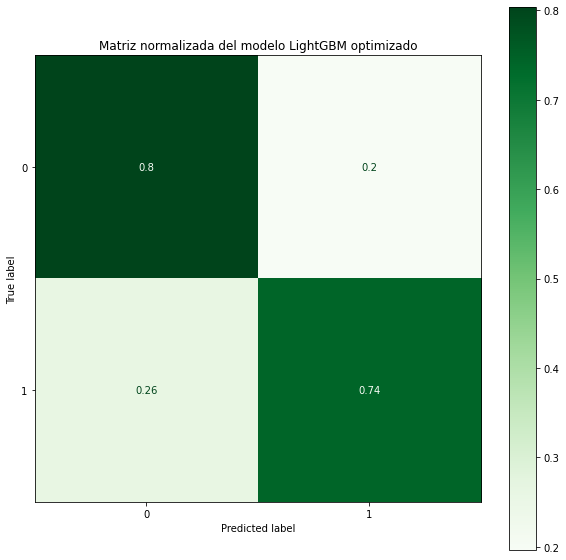

time: 8.62 s (started: 2021-12-16 01:34:35 +01:00)


In [16]:
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize='true',
                                                       ax=ax)
ax.set_title('Matriz normalizada del modelo LightGBM optimizado')

evaluate_model(ytest, ypred, ypred_proba)

El modelo consigue estimar el 74% de los casos positivos (accidentes mortales) manteniendo un 80% de recall en los casos negativos (accidentes no mortales), un balance que hemos considerado óptimo en comparación con el resto de modelos que hemos ejecutado a lo largo de este trabajo.

La principal razón por la que no ha sido necesario realizar un ajuste de threshold en este apartado del trabajo ha sido presumiblemente el uso del parámetro *scoring = 'roc_auc'* a la hora de generar los modelos, como ya hemos comentado previamente.